In [324]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional


import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None) 
pd.set_option('display.float_format', lambda x: '%.f' % x)
pd.set_option('display.expand_frame_repr', False)

In [325]:

data = pd.read_csv('files/dataset.csv')


In [326]:
df=data.copy()
df.head()

,date,0,1,2,3,4,5,6,OT
0,1990/1/1 0:00,1,2,1,1,0,0,1,NaN
1,1990/1/2 0:00,1,2,1,1,0,0,1,NaN
2,1990/1/3 0:00,1,2,1,1,0,0,1,NaN
3,1990/1/4 0:00,1,2,1,1,0,0,1,NaN
4,1990/1/5 0:00,1,2,1,1,NaN,0,1,NaN


# Overview of our dataset 
This function is highly valuable for comprehending the overall structure of the dataset. It offers access to various information, including the dataset’s dimensions, feature names, data types, and the ability to review the first and last 5 rows of the dataset. Furthermore, I aim to uncover valuable patterns and trends within the dataset by analyzing the statistical properties of numerical variables



In [327]:
def check_df(dataset, head = 5):
    print('#'*30 + ' Shape of Dataset' + '#'*30, end = '\n'*2)
    print(dataset.shape, end = '\n'*2)
    print('#'*30 + ' General informations about our Dataset' + '#'*30, end = '\n'*2)
    print(dataset.info(), end = '\n'*2)
    print('#'*30 + ' First 5 Lines Of Dataset' + '#'*30, end = '\n'*2)
    print(dataset.head(head), end = '\n'*2)
    print('#'*30 + ' NaN values of Features' + '#'*30, end = '\n'*2)
    print(dataset.isnull().sum(), end = '\n'*2)
    print('#'*30 + ' Descriptive Statistics of Numerical Features' + '#'*30, end = '\n'*2)
    print(dataset.describe().T, end = '\n'*2)
    print('#'*30 + ' Quantiles of Numerical Features' + '#'*30, end ='\n'*2)
    print(dataset.describe([0,0.10, 0.25, 0.50,0.75,0.99]).T, end = '\n'*2)

check_df(df)

############################## Shape of Dataset##############################

(7488, 9)

############################## General informations about our Dataset##############################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7488 entries, 0 to 7487
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    7488 non-null   object 
 1   0       3331 non-null   float64
 2   1       3313 non-null   float64
 3   2       3327 non-null   float64
 4   3       3326 non-null   float64
 5   4       3466 non-null   float64
 6   5       3392 non-null   float64
 7   6       3191 non-null   float64
 8   OT      3257 non-null   float64
dtypes: float64(8), object(1)
memory usage: 526.6+ KB
None

############################## First 5 Lines Of Dataset##############################

            date  0  1  2  3   4  5  6  OT
0  1990/1/1 0:00  1  2  1  1   0  0  1 NaN
1  1990/1/2 0:00  1  2  1  1   0  0  1 NaN
2  1990/1/3 0:00  1 

# Convert into date format
As the datas are distributed daily ( granularity= 1day) we don't need to precise the hour

In [328]:

df["date"] = pd.to_datetime(df["date"], errors = 'coerce')
df.set_index('date', inplace=True)
df.head()

,0,1,2,3,4,5,6,OT
date,,,,,,,,
1990-01-01,1,2,1,1,0,0,1,NaN
1990-01-02,1,2,1,1,0,0,1,NaN
1990-01-03,1,2,1,1,0,0,1,NaN
1990-01-04,1,2,1,1,0,0,1,NaN
1990-01-05,1,2,1,1,NaN,0,1,NaN


# DATA CLEANING
Filling the missing value with interpolation, forward & backward fill 


In [329]:


# Interpolate missing values for target column "5" and "OT" column
df['5'].interpolate(method='time', inplace=True)
df['OT'].interpolate(method='time', inplace=True)

# Forward fill the remaining missing values in the "OT" column (attempt, later corrected)
df['OT'].fillna(method='ffill', inplace=True)

# Backward fill the remaining missing values in the "OT" column to correct the previous step
df['OT'].fillna(method='bfill', inplace=True)

# Interpolate missing values for all columns, except the already handled "5" and "OT"
columns_to_interpolate = [col for col in df.columns if col not in ['5', 'OT']]
for column in columns_to_interpolate:
    df[column].interpolate(method='time', inplace=True)

# Check for any remaining missing values across the entire dataset
all_missing_values = df.isnull().sum()

In [330]:
check_df(df)

############################## Shape of Dataset##############################

(7488, 8)

############################## General informations about our Dataset##############################

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7488 entries, 1990-01-01 to 2010-07-02
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7488 non-null   float64
 1   1       7488 non-null   float64
 2   2       7488 non-null   float64
 3   3       7488 non-null   float64
 4   4       7488 non-null   float64
 5   5       7488 non-null   float64
 6   6       7488 non-null   float64
 7   OT      7488 non-null   float64
dtypes: float64(8)
memory usage: 526.5 KB
None

############################## First 5 Lines Of Dataset##############################

            0  1  2  3  4  5  6  OT
date                               
1990-01-01  1  2  1  1  0  0  1   1
1990-01-02  1  2  1  1  0  0  1   1
1990-01-03  1  2  1  1  0  0  1   1


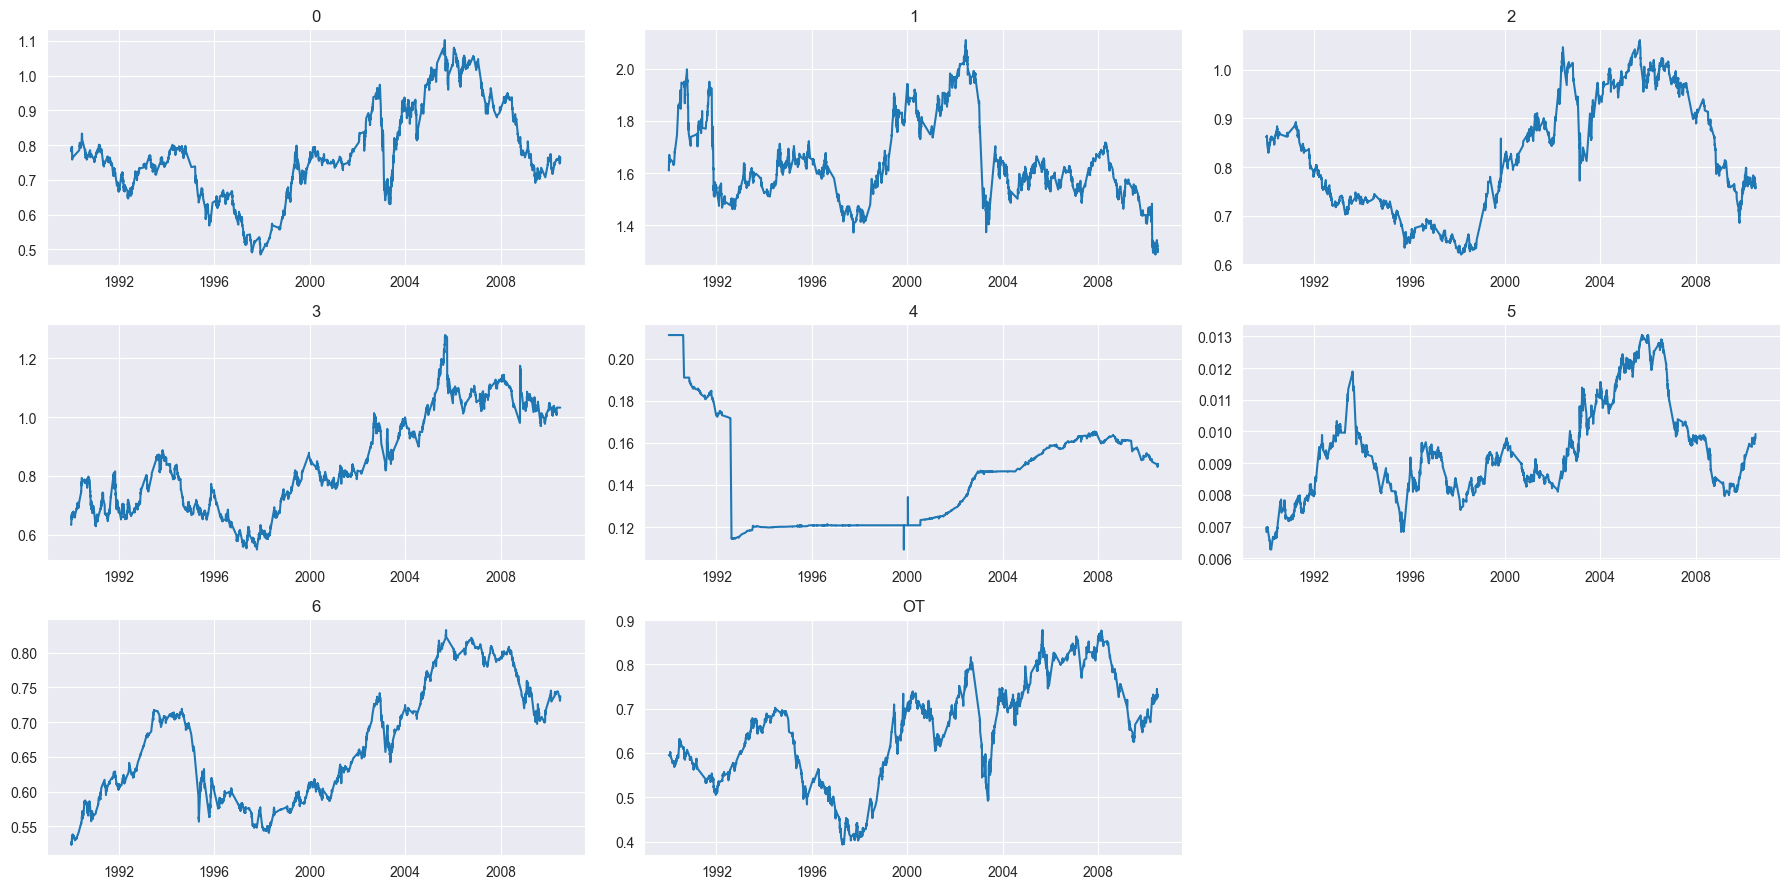

In [331]:
#Plotting my datas
plot_columns = df.select_dtypes(include=['number']).columns
n_cols = len(plot_columns)

# Set up the plotting grid
n_rows = n_cols // 3 + (1 if n_cols % 3 else 0)  # Ensure there's an extra row if needed
fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows*3))  # Adjust figure size as needed

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each column in its subplot
for i, column in enumerate(plot_columns):
    ax = axes[i]
    ax.plot(df[column])
    ax.set_title(column)
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


# Feature Selection/Engineering:
We are choosing the features that are most likely to influence the target variable based on domain knowledge or feature importance analysis.


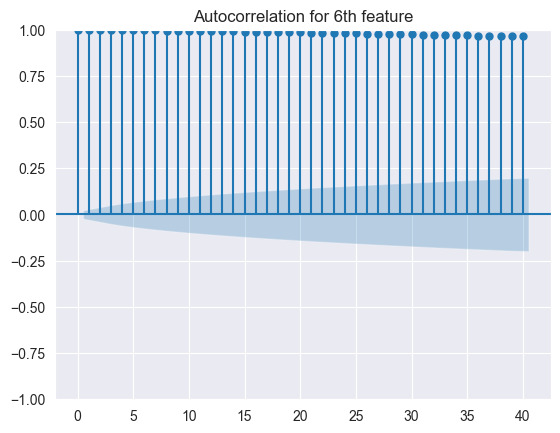

In [332]:
from statsmodels.graphics.tsaplots import plot_acf

# Assuming your DataFrame is named df_filled and 'date' is set as the index
# Plot Autocorrelation for the '6' feature
plot_acf(df['5'], lags=40, alpha=0.05)  # Adjust lags as needed
plt.title('Autocorrelation for 6th feature')
plt.show()

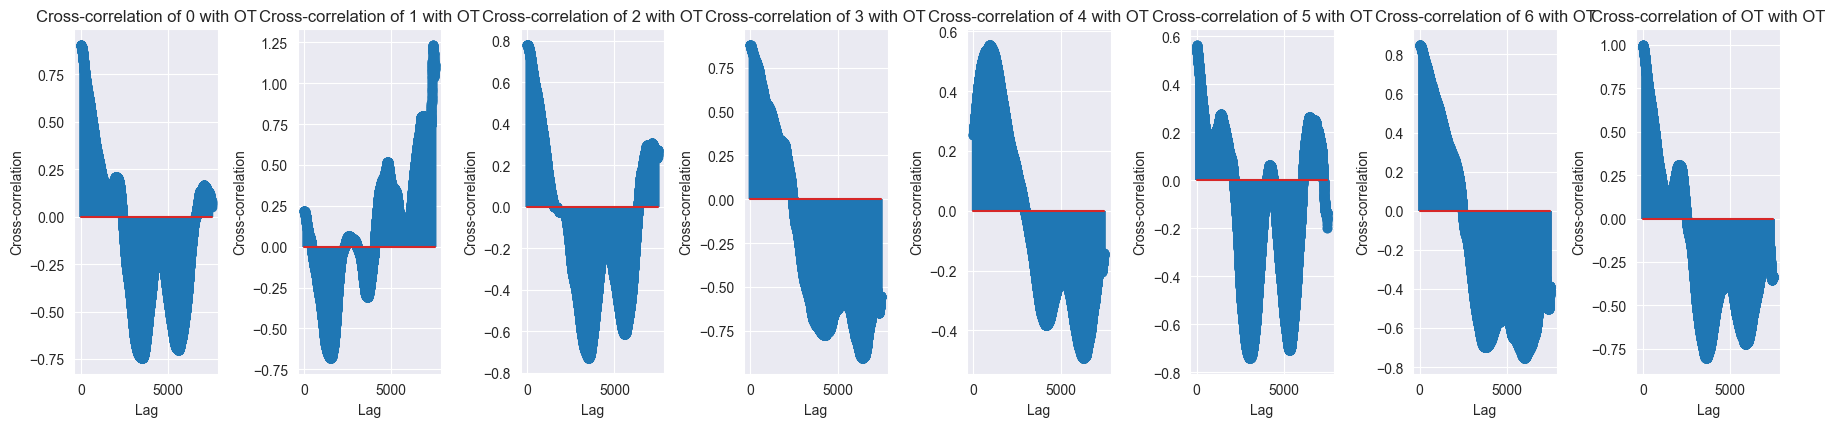

In [333]:

from statsmodels.tsa.stattools import ccf

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows*4))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten to iterate easily

for i, column in enumerate(plot_columns):
    # Compute the cross-correlation again, this time without the 'unbiased' parameter
    cross_correlation = ccf(df[column], df['OT'], adjusted=True)
    
    # Plot without using 'use_line_collection'
    ax = axes[i]
    ax.stem(np.arange(len(cross_correlation)), cross_correlation)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-correlation')
    ax.set_title(f'Cross-correlation of {column} with OT')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [334]:
from sklearn.preprocessing import StandardScaler

Scale=StandardScaler()
def data_prep(df, lookback, future, Scale):
    date_train = df.index
    df_train = df[[ '5', 'OT']]
    df_train = df_train.astype(float)
    
    df_train_scaled = Scale.fit_transform(df_train)

    X, y = [], []
    target_col_index = df_train.columns.tolist().index('5')  # Get the index of the target column "5"
    for i in range(lookback, len(df_train_scaled) - future + 1):
        X.append(df_train_scaled[i - lookback:i, :])  # Use all columns for X
        y.append(df_train_scaled[i + future - 1:i + future, target_col_index])  # Focus on "5" for y
        
    return np.array(X), np.array(y), df_train, date_train


Lstm_x, Lstm_y, df_train, date_train = data_prep(df, 30, 1, Scale)

In [335]:
from tensorflow.keras.layers import Dropout, BatchNormalization
import tensorflow as tf


def Lstm_fallback(X,y):
    model = Sequential()
    
    model.add(LSTM(64, activation='relu',input_shape=(X.shape[1], X.shape[2]),  return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='relu'))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6) 
    model.compile(
            loss='mse',
            optimizer=opt,
        )
    
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X, y, epochs=100, verbose=1, callbacks=[es], validation_split=0.1, batch_size=16)
    return model

In [336]:
def Lstm_model1(X, y):
    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    regressor.fit(X, y, epochs = 100, validation_split=0.1, batch_size = 64, verbose=1, callbacks=[es])
    return regressor

In [337]:


def Lstm_model2(X,y):
    model=Sequential()
    
    model.add(LSTM(20,return_sequences=True,input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    #model.add(LSTM(15,return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    adam = optimizers.Adam(0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(X, y,validation_split=0.2,epochs=100,batch_size=64,verbose=1, callbacks=[es])
    return model


In [338]:
def predict_open(model,date_train,Lstm_x,df_train, future, Scale):
    forecasting_dates=pd.date_range(list(date_train)[-1], periods=future, freq='1d').tolist()
    predicted=model.predict(Lstm_x[-future:])
    predicted1=np.repeat(predicted, df_train.shape[1], axis=-1)
    predicted_descaled=Scale.inverse_transform(predicted1)[:,0]
    return predicted_descaled,forecasting_dates

def output_prep(forecasting_dates, predicted_descaled):
    # Assuming forecasting_dates is a list of pandas Timestamps, since date is your index
    dates = [i.date() for i in forecasting_dates]  # Convert Timestamps to dates
    
    df_final = pd.DataFrame(columns=['Date', '5'])  # It looks like you intended to have another column, but then you use 'Open'
    df_final['Date'] = pd.to_datetime(dates)  # Convert dates list back to datetime to use as a column
    df_final['5'] = predicted_descaled  # Assign the predicted descaled values to 'Open'
    
    return df_final

In [339]:
import plotly.express as px
def results(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model1(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=30
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,future, Scale)
    results=output_prep(forecasting_dates,predicted_descaled)   
    print(results.head())
    plt.show()
    fig = px.area(results, y="5", title=x)
    fig.show()

In [340]:
def results1(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model2(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=30
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,future, Scale)
    results=output_prep(forecasting_dates,predicted_descaled)   
    print(results.head())
    plt.show()
    fig = px.area(results, y="5", title=x)
    fig.show()

In [341]:
results(df, 100, 1, Scale, '5')


Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 555ms/step - loss: 0.1729 - val_loss: 0.0084
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 565ms/step - loss: 0.0150 - val_loss: 0.0044
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 563ms/step - loss: 0.0122 - val_loss: 0.0050
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 566ms/step - loss: 0.0138 - val_loss: 0.0036
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 555ms/step - loss: 0.0099 - val_loss: 0.0035
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 587ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 607ms/step - loss: 0.0099 - val_loss: 0.0034
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 596ms/step - loss: 0.0097 - val_loss: 0.0035
Epoch 9/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 10/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 563ms/step - loss: 0.0095 - val_loss: 0.0028
Epoch 11/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 578ms/step - loss: 0.0108 - val_loss: 0.0039
Epoch 12/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 39

KeyboardInterrupt: 

In [ ]:
results1(df, 100, 1, Scale, '5')


In [ ]:

plt.show()